In [2]:
from agm_te.dataset import DataSet
from agm_te.mlmodel import train_RNNDynamicsModel, plot_RNNDynamicsModel_pred, init_dynamicsmodels_from_loaders, predict_with_RNNDynamicsModel
import numpy as np
from te_datasim.lineargaussian import BVLinearGaussianSimulator
import matplotlib.pyplot as plt
from te_datasim.neural import NeuralSimulator

In [3]:
import torch; torch.set_printoptions(sci_mode=None)
# Check if CUDA is available
if torch.cuda.is_available():
    compute_device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    compute_device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [4]:
# Example connectivity matrix
A = np.array([
    [-1, 0.2, 0.1], 
    [0.5, -1, 0.0], 
    [0.1, 0.1, -1]
    ])
# Example transfer matrix
C = np.array([
    [1, 0, 0.1], 
    [0, 0.1, 1],
    [0.1, 1, 0.3]
    ])
simulator = NeuralSimulator(A, C)

data_dict = {'X':[], 'Y':[]}
for i in range(50):
    input_signals, neural_activity, bold_signal, spike_counts = simulator.simulate(1000, seed=i)
    data_dict['X'].append(input_signals)
    data_dict['Y'].append(neural_activity)

neural_data = DataSet(data_dict)

Epoch [2000/2000], Model 1 Loss: 1.050535, Model 2 Loss: 1.005798, Estimated TE: 0.0447
Transfer Entropy Y -> X estimated at:  0.0447


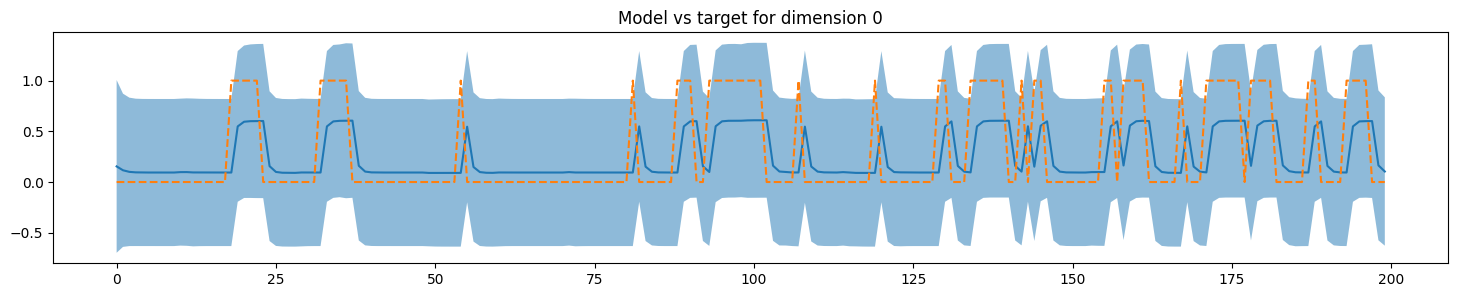

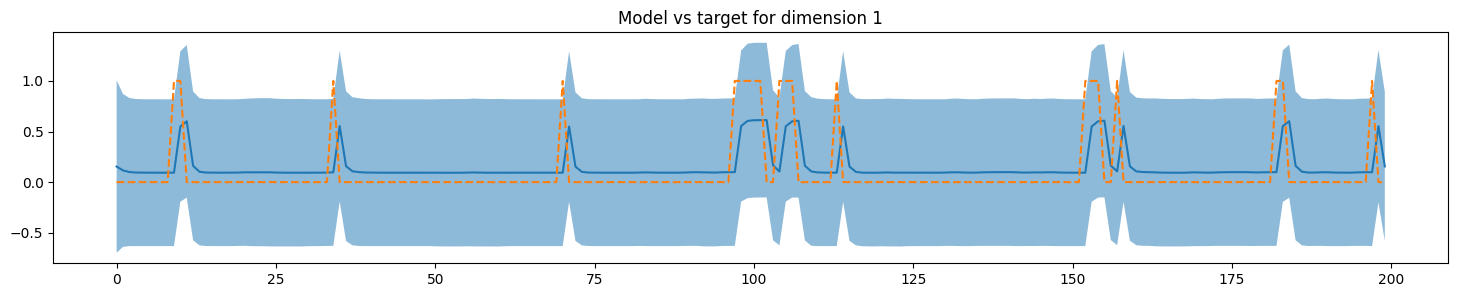

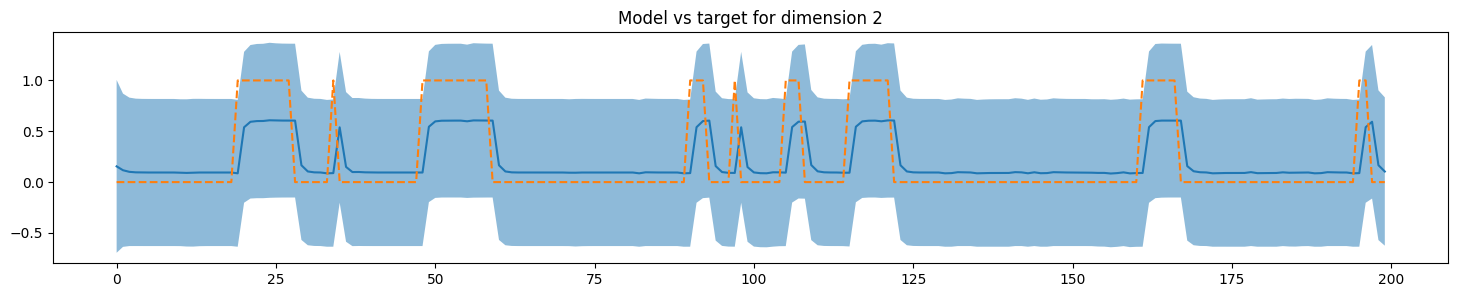

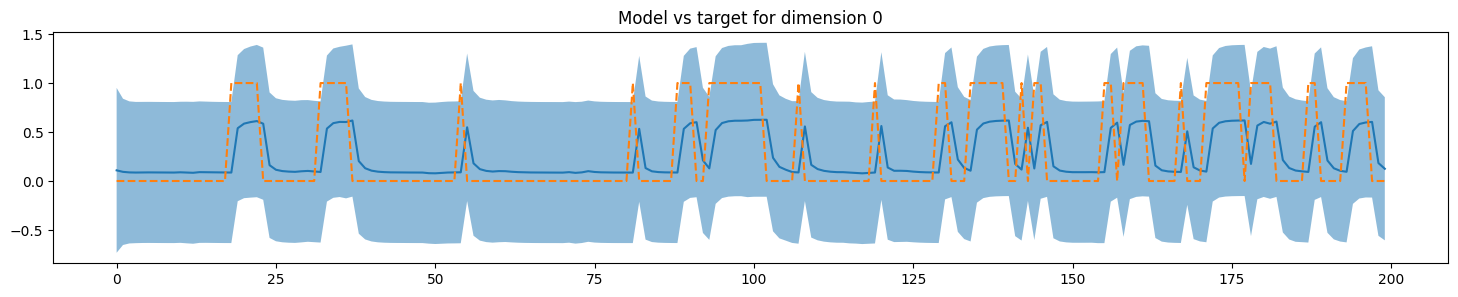

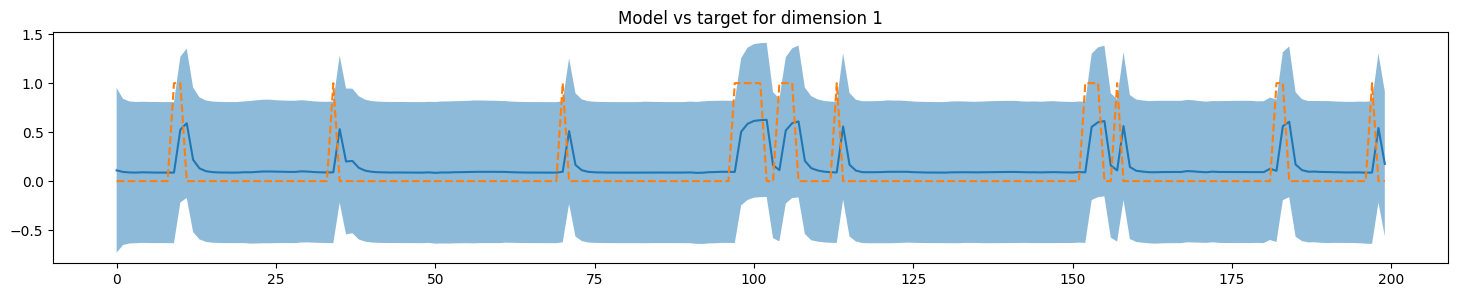

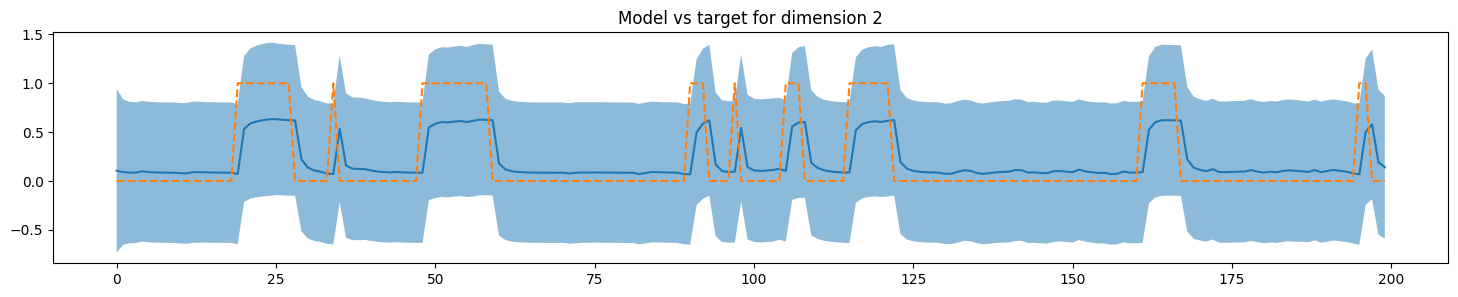

Epoch [2000/2000], Model 1 Loss: -0.408871, Model 2 Loss: -0.970033, Estimated TE: 0.5612
Transfer Entropy X -> Y estimated at:  0.5612


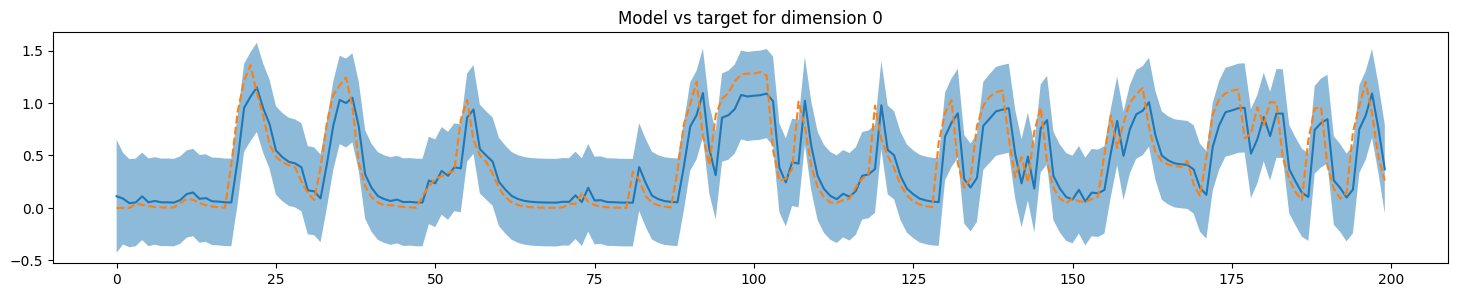

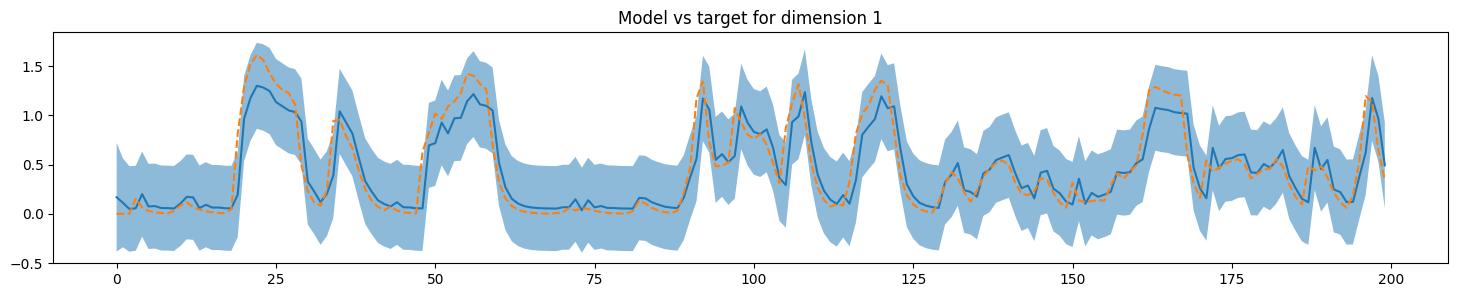

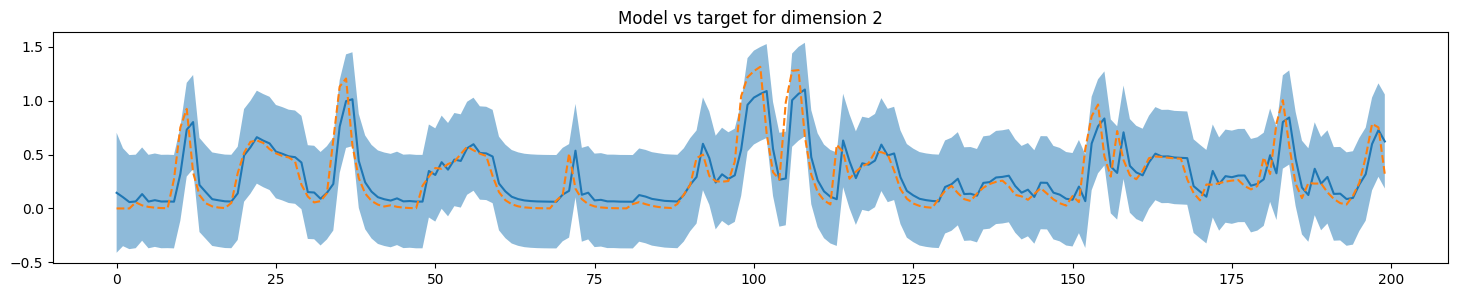

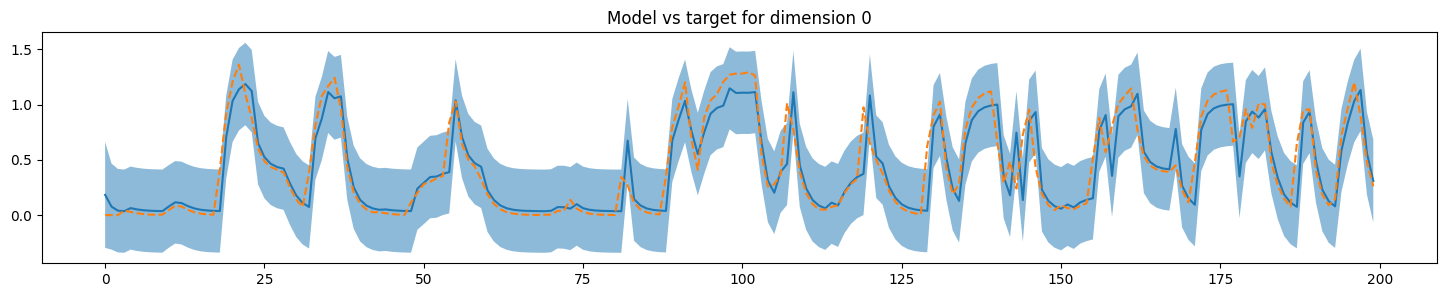

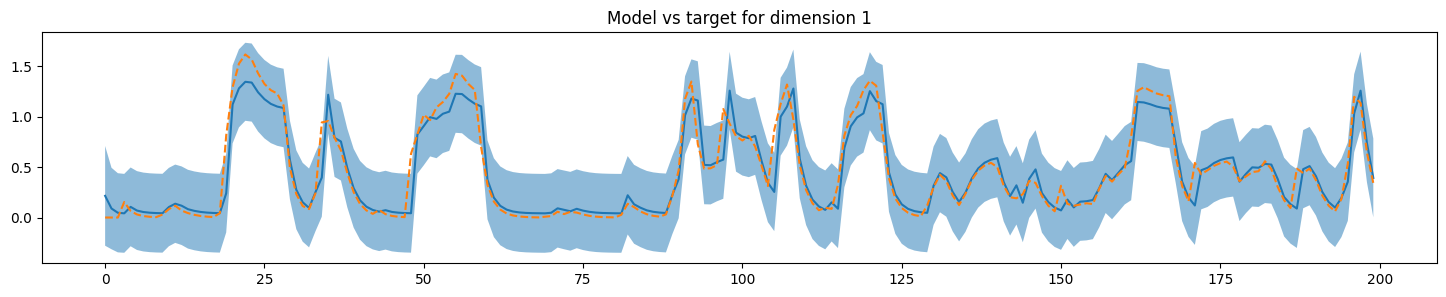

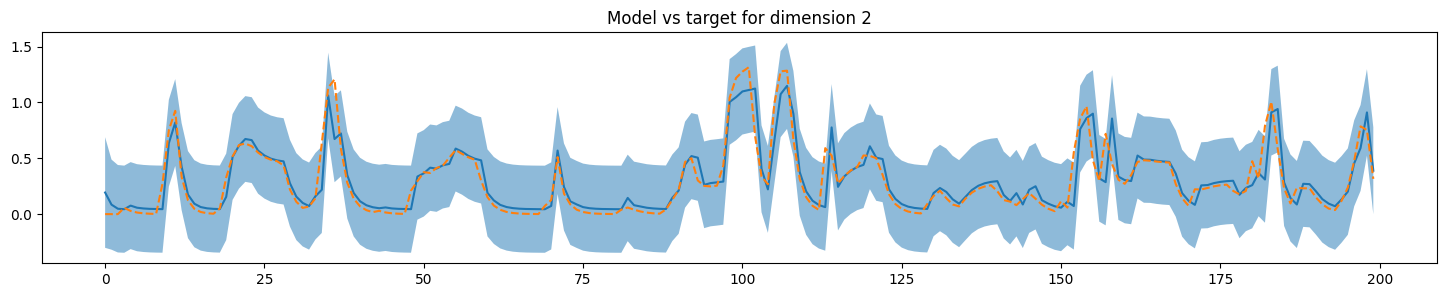

In [8]:
dataloader_1, dataloader_2 = neural_data.get_TE_dataloaders(device=compute_device, var_from='Y', var_to='X', batch_size=25)
model_1, model_2 = init_dynamicsmodels_from_loaders(dataloader_1, dataloader_2, rnn_type='RNN', hidden_size=6, num_layers=1)
model_1, model_2, loss = train_RNNDynamicsModel(model_1, dataloader_1, model_2, dataloader_2, epochs=2000, learning_rate=1e-3, l2_penalty=0.1, optimize='adam')
print("Transfer Entropy Y -> X estimated at: ", loss)
plot_RNNDynamicsModel_pred(model_1, dataloader_1, batch_index=0, traj_idx = 13, plot_start=0, plot_end = 200, by_dim=True)
plot_RNNDynamicsModel_pred(model_2, dataloader_2, batch_index=0, traj_idx = 13, plot_start=0, plot_end = 200, by_dim=True)

dataloader_1, dataloader_2 = neural_data.get_TE_dataloaders(device=compute_device, var_from='X', var_to='Y', batch_size=25)
model_1, model_2 = init_dynamicsmodels_from_loaders(dataloader_1, dataloader_2, rnn_type='RNN', hidden_size=6, num_layers=1)
model_1, model_2, loss = train_RNNDynamicsModel(model_1, dataloader_1, model_2, dataloader_2, epochs=2000, learning_rate=1e-3, l2_penalty=0.1, optimize='adam')
print("Transfer Entropy X -> Y estimated at: ", loss)
plot_RNNDynamicsModel_pred(model_1, dataloader_1, batch_index=0, traj_idx = 13, plot_start=0, plot_end = 200, by_dim=True)
plot_RNNDynamicsModel_pred(model_2, dataloader_2, batch_index=0, traj_idx = 13, plot_start=0, plot_end = 200, by_dim=True)

/home/dan/Cloud/Projects/2023_UCL_Causal_Direction/AGM-TE/agm_te/mlmodel.py:489: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_to_past[0] = torch.tensor(var_to_start).to(model.device)


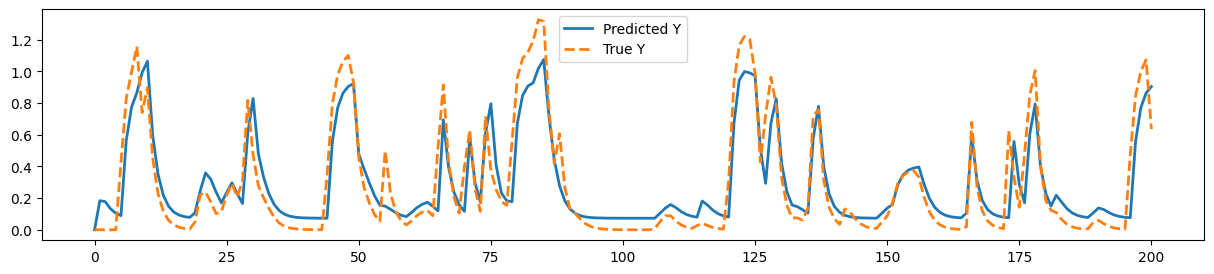

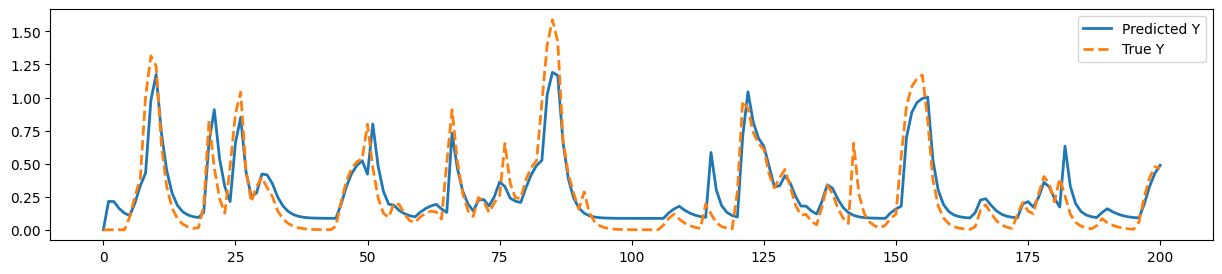

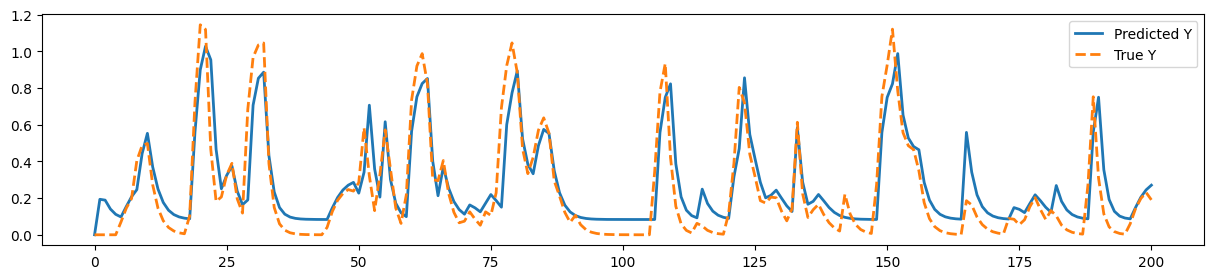

In [10]:
input_signals, neural_activity, bold_signal, spike_counts = simulator.simulate(200, seed=10000)

X = np.array(input_signals, dtype=np.float32)
Y = np.array(neural_activity, dtype=np.float32)

pred = predict_with_RNNDynamicsModel(model_2, X, Y[0], random_rep = 0)
for i in range(0, Y.shape[1]):
    plt.figure(figsize=(15, 3))
    plt.plot(pred[:,i], label='Predicted Y', linewidth=2)
    plt.plot(Y[:,i], label='True Y', linestyle='--', linewidth=2)
    plt.legend()

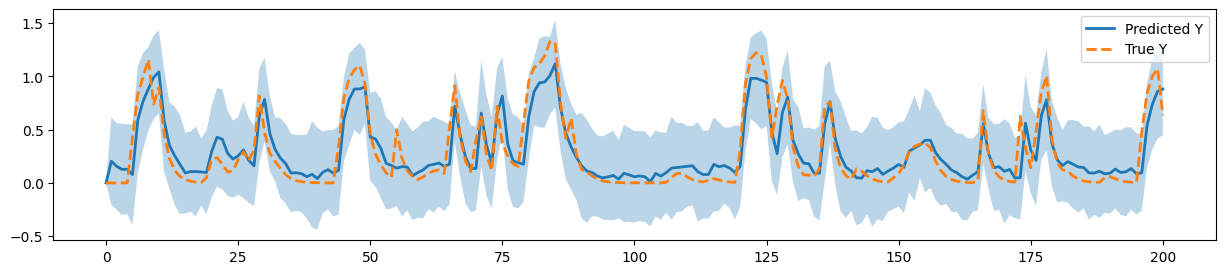

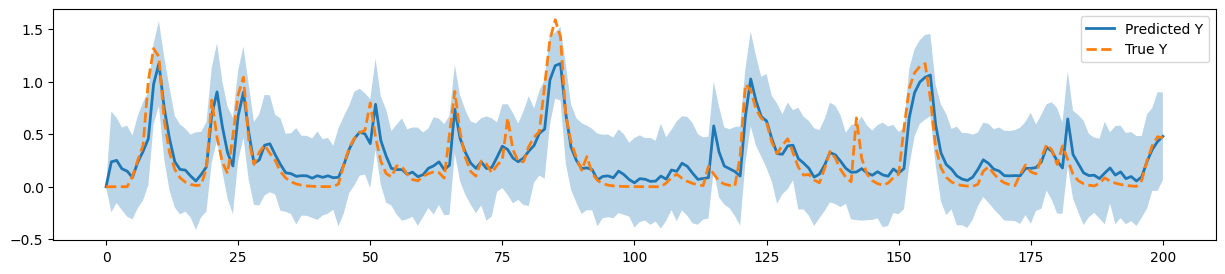

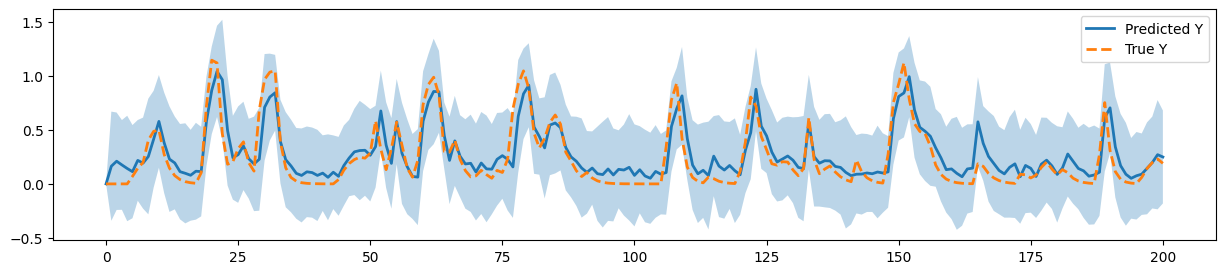

In [11]:
pred_mean, pred_std = predict_with_RNNDynamicsModel(model_2, X, Y[0], random_rep = 50)
for i in range(0, Y.shape[1]):
    plt.figure(figsize=(15, 3))
    plt.plot(pred_mean[:,i], label='Predicted Y', linewidth=2)
    plt.fill_between(np.arange(0, 201), pred_mean[:,i]-pred_std[:,i]*2, pred_mean[:,i]+pred_std[:,i]*2, alpha=0.3)
    plt.plot(Y[:,i], label='True Y', linestyle='--', linewidth=2)
    plt.legend()